Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pylab as plt 
from matplotlib import cm

import os
import math
import numpy as np
import pandas as pd
import cma
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, Callback
import tensorflow.keras.backend as K

from IPython.display import clear_output
from time import time, gmtime, strftime, localtime

import warnings
warnings.filterwarnings("ignore")

2022-12-14 14:29:29.327104: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from scipy import dot, exp, log, sqrt, floor, ones, randn, zeros_like, Inf, argmax, argmin, eye, outer, zeros
from scipy import array, power, diag, cos, sin, pi
from scipy.linalg import expm, cholesky, solve, norm, eig
from scipy.stats import multivariate_normal

import seaborn as sns

# ## run on CPU...
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# run on GPU...
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# disable eager excution
tf.compat.v1.disable_eager_execution()

### 1. PINN for projectile motion equation

#### 1.0. Data

In [3]:
# function to generate analytical solution
def f_x(t):
    return x0 + t*u0

def f_y(t):
    return y0 + t*v0 - 1./2*g*t**2

def f_t():
    return (vel0*sin(a0*pi/180) + sqrt((vel0*sin(a0*pi/180))**2 + 2*g*y0)) / g

# free fall
def terminal_vel():
    vinf = sqrt(2*m*g / (d*Cd*A))
    return vinf

def f_yfree(t, vinf):
    y_free = y0 - vinf**2/g*log(np.cosh(g*t/vinf))
    return y_free

#### 1.1. Geometry, PDE parameter & BC

In [4]:
# specify planet to change g, d & a_T
# planet = {'earth': (9.8, 1.2, 2), 'mars': (3.7, 0, 4.5), 'moon': (1.6, 0, 10)}
planet = {'earth': (9.8, 0, 2), 'mars': (3.7, 0, 5.5), 'moon': (1.6, 0, 8)}
g, d, a_T = planet['mars']

# parameter related to flying ball (constant)
m = 0.6
r = 0.12
Cd = 0.54
A = pi*r**2

# initial condition @(x, y) position
x0, y0 = 0, 2
# initial condition @velocity
vel0 = 10         

# angle of projectile
a0 = 80

# initial velocity
u0 = vel0 * cos(a0*pi/180)
v0 = vel0 * sin(a0*pi/180)

# time domain: 0 - t_T
t_T = a_T    # let it fly..

#### 1.2. Sampling plan

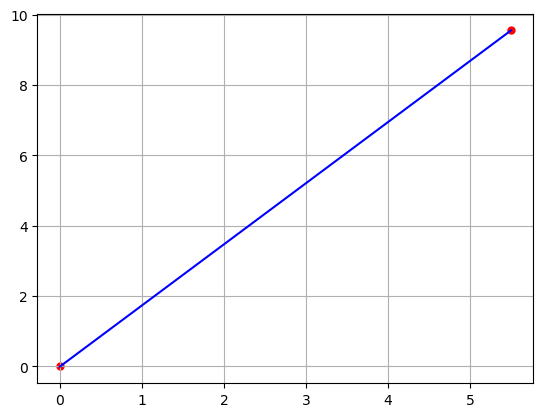

In [5]:
n_pde=10000
# n_ic=10
t_eval = np.linspace(0, t_T, n_pde).reshape(-1, 1)
# PDE Data
data_pde = np.hstack([t_eval, np.ones((len(t_eval), 1))])
x_eval = f_x(t_eval)
y_eval = f_y(t_eval)

# BC sample
bc = np.where((t_eval == 0) | (t_eval == t_T))[0]
t_bc, x_bc = t_eval[bc], x_eval[bc]
t_bc, y_bc = t_eval[bc], y_eval[bc]
# visualize x plot
plt.plot(t_eval, x_eval, c='blue'); plt.grid();
plt.scatter(t_bc, x_bc, c='red', s=25, marker='o');

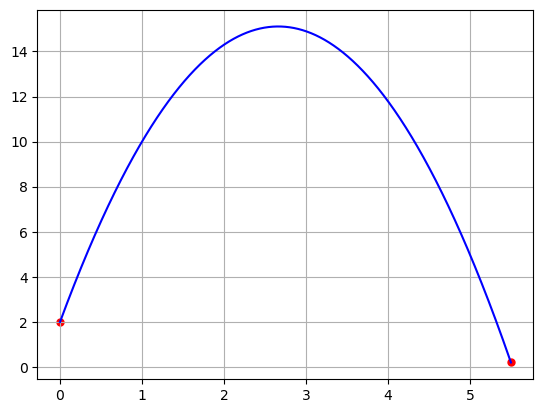

In [6]:
# visualize y plot
plt.plot(t_eval, y_eval, c='blue'); plt.grid();
plt.scatter(t_bc, y_bc, c='red', s=25, marker='o');

#### 1.3. PDE-NN

In [7]:
# specify FF-PINN
def create_nn(n_nodes):

    # # input layers -> x
    # x = layers.Input(shape=(1,))
    # input layers -> split into (x, w)
    inputs = layers.Input(shape=(2,))
    t, z = layers.Lambda( lambda k: tf.split(k, num_or_size_splits=2, axis=1))(inputs)

    # initializer  
    initializer = tf.keras.initializers.GlorotUniform()  # hidden layers initializer
    
    # hidden layers
    hidden_1 = layers.Dense(n_nodes, use_bias=False, activation='tanh')(t)
    hidden_2 = layers.Dense(n_nodes, activation='tanh')(hidden_1)

    # split layers
    hidden_x = layers.Dense(n_nodes, activation='tanh')(hidden_2)
    hidden_y = layers.Dense(n_nodes, activation='tanh')(hidden_2)

    # output layers
    x = layers.Dense(1, use_bias=False, name="x")(hidden_x)
    y = layers.Dense(1, use_bias=False, name="y")(hidden_y)
    outputs = layers.Concatenate()([x, y])

    # axillary PDE outputs
    x_t, y_t = K.gradients(x, t)[0], K.gradients(y, t)[0]
    x_tt, y_tt = K.gradients(x_t, t)[0], K.gradients(y_t, t)[0]

    # consider drag effect
    V = tf.math.sqrt( (x_t)**2 + (y_t)**2 )
    C = 0.5*d*Cd*A/m
    R = C*V

    pde_x = x_tt + R*x_t
    pde_y = y_tt + R*y_t + g

    # PDE residuals (physics laws)
    pde_residuals_x = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(pde_x), predictions=pde_x)
    pde_residuals_y = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(pde_y), predictions=pde_y)
    pde_mse = pde_residuals_x + pde_residuals_y

    # initial conditions (which define the problem)
    
    x_0, y_0 = tf.boolean_mask(x, tf.equal(t, 0)), tf.boolean_mask(y, tf.equal(t, 0))
    x_t0, y_t0 = tf.boolean_mask(x_t, tf.equal(t, 0)), tf.boolean_mask(y_t, tf.equal(t, 0))
    ic_1 = tf.compat.v1.losses.mean_squared_error(labels=tf.ones_like(x_0)*x0, predictions=x_0)
    ic_2 = tf.compat.v1.losses.mean_squared_error(labels=tf.ones_like(x_t0)*u0, predictions=x_t0)
    ic_3 = tf.compat.v1.losses.mean_squared_error(labels=tf.ones_like(y_0)*y0, predictions=y_0)
    ic_4 = tf.compat.v1.losses.mean_squared_error(labels=tf.ones_like(y_t0)*v0, predictions=y_t0)

    # sum up all initial conditions
    ic_mse = ic_1 + ic_2 + ic_3 + ic_4

    # initiate model
    nn = models.Model(inputs=inputs, outputs=outputs)

    # optimizer
    optimizer = tf.keras.optimizers.Adam(0.05)

    # compile model with [physics] loss
    nn.compile(loss = compute_physic_loss(pde_mse, ic_mse),
               optimizer = optimizer,
               metrics = [compute_pde_loss(pde_mse), compute_ic_loss(ic_mse)])

    # pathway to variables inside NN
    insiders = [x, y, pde_mse, ic_mse]
    eval_ins = K.function([nn.input, K.learning_phase()], insiders)   # evaluation function

    return (nn, eval_ins)

In [8]:
# define loss function (PDE + IC loss)
def compute_physic_loss(pde_mse, ic_mse):
    def physic_loss(y_true, y_pred):
        pde_loss  = pde_mse # PDE
        ic_loss   = ic_mse  # IC
        return pde_loss + ic_loss
    return physic_loss

# define loss function (PDE loss)
def compute_pde_loss(pde_mse):
    def pde_loss(y_true, y_pred): return pde_mse
    return pde_loss # return a function

# define loss function (IC loss)
def compute_ic_loss(ic_mse):
    def ic_loss(y_true, y_pred): return ic_mse
    return ic_loss # return a function

# define loss function (data loss)
def compute_data_loss(z):
    def data_loss(y_true, y_pred):
        p_data = tf.equal(z, 1)
        return tf.losses.mean_squared_error(labels=tf.boolean_mask(y_true, p_data), predictions=tf.boolean_mask(y_pred, p_data))
    return data_loss

### 3. Optimize PINN with [Neuroevolution / xNES]

In [9]:
# initiate NN model (& pathway to internal values)
n_nodes = 8
nn, eval_ins = create_nn(n_nodes)

# initial weights
w0 = np.array([])
nn_weights = nn.get_weights()
for _g in nn_weights: w0 = np.append(w0, _g.flatten())

nn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 [(None, 1), (None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            8           lambda[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            72          dense[0][0]                      
______________________________________________________________________________________________

2022-12-14 14:29:34.000182: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-12-14 14:29:34.037063: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-14 14:29:34.037090: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ihpcgs-02
2022-12-14 14:29:34.037096: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ihpcgs-02
2022-12-14 14:29:34.037203: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-12-14 14:29:34.037226: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-12-14 14:29:34.037231: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-12-14 14:29:34.037564: I tensorflow/core/platform/cpu_fe

In [10]:
# nn weights structure 
nn_weights = nn.get_weights()
nn_wlen = len(nn_weights)
nn_wshape = [_w.shape for _w in nn_weights]
nn_widx = np.cumsum([len(_w.flatten()) for _w in nn_weights])
nn_nweights = nn_widx[-1]

In [11]:
# sample generator
# DGEN = SamplingPlan(data=(X_bc, y_bc), batch_size=(500, 2))

# function to evaluate fitness given the weights
def nn_fitness(_weights):
    _weights = np.split(_weights, nn_widx[:-1])
    _weights = [_weights[i].reshape(nn_wshape[i]) for i in range(nn_wlen)]
    nn.set_weights(_weights)
    # _x, _ = DGEN.__getitem__(0)
    _x = data_pde
    _, _, pde_mse, ic_mse = eval_ins(_x)
    fitness = (pde_mse + ic_mse)
    return fitness

In [12]:
x, es = cma.fmin2(nn_fitness, w0, 0.001, options={'ftarget':1e-5, 'popsize':80, 'maxiter':450, 'verb_disp':1})

(40_w,80)-aCMA-ES (mu_w=21.8,w_1=9%) in dimension 240 (seed=1022048, Wed Dec 14 14:29:34 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     80 1.560070800781250e+02 1.0e+00 9.57e-04  1e-03  1e-03 0:00.6
    2    160 1.558770294189453e+02 1.0e+00 9.28e-04  9e-04  9e-04 0:01.0
    3    240 1.557900238037109e+02 1.0e+00 9.12e-04  9e-04  9e-04 0:01.4
    4    320 1.556161651611328e+02 1.0e+00 9.03e-04  9e-04  9e-04 0:01.8
    5    400 1.555374755859375e+02 1.0e+00 9.06e-04  9e-04  9e-04 0:02.2
    6    480 1.553880310058594e+02 1.0e+00 9.17e-04  9e-04  9e-04 0:02.7
    7    560 1.551880340576172e+02 1.0e+00 9.36e-04  9e-04  9e-04 0:03.1
    8    640 1.550873870849609e+02 1.0e+00 9.63e-04  1e-03  1e-03 0:03.5
    9    720 1.549327087402344e+02 1.0e+00 9.98e-04  1e-03  1e-03 0:03.9
   10    800 1.547735137939453e+02 1.0e+00 1.04e-03  1e-03  1e-03 0:04.4
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   11    880 1.545397949218750e

  102   8160 1.447040176391602e+01 1.1e+00 2.26e-01  2e-01  2e-01 0:43.0
  103   8240 1.453429126739502e+01 1.1e+00 2.26e-01  2e-01  2e-01 0:43.4
  104   8320 1.231108570098877e+01 1.1e+00 2.26e-01  2e-01  2e-01 0:43.8
  105   8400 1.416620159149170e+01 1.1e+00 2.26e-01  2e-01  2e-01 0:44.3
  106   8480 1.418515300750732e+01 1.1e+00 2.26e-01  2e-01  2e-01 0:44.7
  107   8560 1.342342185974121e+01 1.1e+00 2.25e-01  2e-01  2e-01 0:45.1
  108   8640 1.378735923767090e+01 1.1e+00 2.23e-01  2e-01  2e-01 0:45.5
  109   8720 1.504491043090820e+01 1.1e+00 2.23e-01  2e-01  2e-01 0:46.0
  110   8800 1.449483013153076e+01 1.1e+00 2.22e-01  2e-01  2e-01 0:46.4
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
  111   8880 1.227855110168457e+01 1.1e+00 2.22e-01  2e-01  2e-01 0:46.9
  112   8960 1.361023521423340e+01 1.1e+00 2.22e-01  2e-01  2e-01 0:47.3
  113   9040 1.285007190704346e+01 1.1e+00 2.22e-01  2e-01  2e-01 0:47.7
  114   9120 1.357168865203857e+01 1.1e+00 2.22e-01 

  205  16400 9.409147262573242e+00 1.3e+00 1.77e-01  2e-01  2e-01 1:26.5
  206  16480 9.713071823120117e+00 1.3e+00 1.76e-01  2e-01  2e-01 1:26.9
  207  16560 9.781150817871094e+00 1.3e+00 1.75e-01  2e-01  2e-01 1:27.3
  208  16640 9.975298881530762e+00 1.3e+00 1.74e-01  2e-01  2e-01 1:27.7
  209  16720 1.020500659942627e+01 1.3e+00 1.73e-01  2e-01  2e-01 1:28.2
  210  16800 8.605132102966309e+00 1.3e+00 1.72e-01  2e-01  2e-01 1:28.6
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
  211  16880 9.789642333984375e+00 1.3e+00 1.71e-01  2e-01  2e-01 1:29.0
  212  16960 9.911961555480957e+00 1.3e+00 1.70e-01  2e-01  2e-01 1:29.4
  213  17040 9.464010238647461e+00 1.3e+00 1.70e-01  2e-01  2e-01 1:29.8
  214  17120 9.793717384338379e+00 1.3e+00 1.69e-01  2e-01  2e-01 1:30.2
  215  17200 1.044831562042236e+01 1.3e+00 1.69e-01  2e-01  2e-01 1:30.6
  216  17280 9.982038497924805e+00 1.3e+00 1.70e-01  2e-01  2e-01 1:31.1
  217  17360 1.001115989685059e+01 1.3e+00 1.70e-01 

  308  24640 8.653956413269043e+00 1.5e+00 1.65e-01  2e-01  2e-01 2:09.3
  309  24720 9.105721473693848e+00 1.5e+00 1.66e-01  2e-01  2e-01 2:09.7
  310  24800 1.001070690155029e+01 1.5e+00 1.67e-01  2e-01  2e-01 2:10.1
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
  311  24880 8.597775459289551e+00 1.5e+00 1.67e-01  2e-01  2e-01 2:10.6
  312  24960 8.509607315063477e+00 1.5e+00 1.67e-01  2e-01  2e-01 2:11.0
  313  25040 9.599982261657715e+00 1.5e+00 1.68e-01  2e-01  2e-01 2:11.4
  314  25120 9.065291404724121e+00 1.5e+00 1.69e-01  2e-01  2e-01 2:11.8
  315  25200 9.412505149841309e+00 1.5e+00 1.71e-01  2e-01  2e-01 2:12.2
  316  25280 9.475854873657227e+00 1.5e+00 1.73e-01  2e-01  2e-01 2:12.6
  317  25360 8.924232482910156e+00 1.5e+00 1.74e-01  2e-01  2e-01 2:13.0
  318  25440 9.333202362060547e+00 1.5e+00 1.76e-01  2e-01  2e-01 2:13.4
  319  25520 9.697058677673340e+00 1.5e+00 1.77e-01  2e-01  2e-01 2:13.8
  320  25600 8.608031272888184e+00 1.5e+00 1.79e-01 

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
  411  32880 7.605893611907959e+00 1.6e+00 1.34e-01  1e-01  1e-01 2:52.3
  412  32960 7.517941474914551e+00 1.6e+00 1.33e-01  1e-01  1e-01 2:52.6
  413  33040 6.887630939483643e+00 1.6e+00 1.33e-01  1e-01  1e-01 2:53.1
  414  33120 7.068048954010010e+00 1.6e+00 1.32e-01  1e-01  1e-01 2:53.5
  415  33200 7.210905551910400e+00 1.6e+00 1.32e-01  1e-01  1e-01 2:53.9
  416  33280 6.959447860717773e+00 1.6e+00 1.31e-01  1e-01  1e-01 2:54.4
  417  33360 7.407562732696533e+00 1.6e+00 1.30e-01  1e-01  1e-01 2:54.8
  418  33440 7.107795238494873e+00 1.6e+00 1.29e-01  1e-01  1e-01 2:55.2
  419  33520 6.928329944610596e+00 1.6e+00 1.27e-01  1e-01  1e-01 2:55.6
  420  33600 7.271086692810059e+00 1.6e+00 1.26e-01  1e-01  1e-01 2:56.0
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
  421  33680 6.915805339813232e+00 1.6e+00 1.25e-01  1e-01  1e-01 2:56.4
  422  33760 7.532839775085449e+00 1.6e+00 1.23e-01  